## PPC

In [1]:
import sys
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap
import sparse

sns.set(context="notebook", font_scale=1.3, style="ticks")
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite=False

sys.path.append("../utils/")
from totalppc import TotalPosteriorPredictiveCheck as totalPPC
from scvi import set_seed

# colors = ["#9b59b6", "#3498db", "#95a5a6", "#34495e", "#e74c3c", "#2ecc71"]
# colors_3 = ["#9b59b6", "#95a5a6", "#34495e", "#e74c3c", "#2ecc71"]

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
colors_3 = ["#3B7EA1", "#D9661F", "#859438", "#EE1F60", "#00A598"]

set_seed(0)

In [2]:
anndataset_sln = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_sln = anndataset_sln[anndataset_sln.obs["batch_indices"] == 0]

In [3]:
# Removes HTOs
dataset_sln = AnnDatasetFromAnnData(ad=anndataset_sln)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_sln.obsm["protein_expression"][:, :-2].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_sln.uns["protein_names"][:-2],
)
dataset_sln.initialize_cell_measurement(protein_data)

datasets = [dataset_sln]

[2020-09-01 16:26:03,893] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-01 16:26:03,895] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-01 16:26:04,097] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-01 16:26:04,336] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells


In [4]:
for d in datasets:
    d.update_genes(d.var["highly_variable"])

[2020-09-01 16:26:04,379] INFO - scvi.dataset.dataset | Downsampling from 13553 to 4000 genes
[2020-09-01 16:26:04,523] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-01 16:26:04,621] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-09-01 16:26:04,718] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-01 16:26:04,779] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells


In [5]:
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

In [8]:
vaes = []
trainers = []

for i in range(5):
    vae_pbmc = TOTALVI(dataset_sln.nb_genes, len(dataset_sln.protein_names))
    vaes.append(vae_pbmc)
    trainer_pbmc = TotalTrainer(
        vae_pbmc,
        dataset_sln,
        train_size=0.80,
        test_size=0.05,
        use_cuda=use_cuda,
        frequency=1,
        data_loader_kwargs={"batch_size":256, "pin_memory":False},
        early_stopping_kwargs=early_stopping_kwargs,
        seed=i
    )
    trainer_pbmc.train(lr=lr, n_epochs=500)
    trainers.append(trainer_pbmc)

[2020-09-01 16:42:25,112] INFO - scvi.inference.trainer | Reducing LR on epoch 431.
[2020-09-01 16:43:44,682] INFO - scvi.inference.trainer | Reducing LR on epoch 475.



[2020-09-01 16:59:01,450] INFO - scvi.inference.trainer | Reducing LR on epoch 419.
[2020-09-01 17:00:57,419] INFO - scvi.inference.trainer | Reducing LR on epoch 476.



[2020-09-01 17:14:44,017] INFO - scvi.inference.trainer | Reducing LR on epoch 362.
[2020-09-01 17:16:46,259] INFO - scvi.inference.trainer | Reducing LR on epoch 418.
[2020-09-01 17:18:53,131] INFO - scvi.inference.trainer | Reducing LR on epoch 475.



[2020-09-01 17:33:55,380] INFO - scvi.inference.trainer | Reducing LR on epoch 446.
[2020-09-01 17:34:39,364] INFO - scvi.inference.trainer | Reducing LR on epoch 483.



[2020-09-01 17:44:07,795] INFO - scvi.inference.trainer | Reducing LR on epoch 468.



In [9]:
post_pbmcs = [t.train_set for t in trainers]

In [10]:
ppc_helds_pbmc = []
ppc_fulls_pbmc = []

for i in range(5):
    ppc_helds_pbmc.append(totalPPC(
        posteriors_dict={"totalVI_{}".format(i): trainers[i].validation_set},
        n_samples=150,
    ))
    ppc_fulls_pbmc.append(totalPPC(
        posteriors_dict={"totalVI_{}".format(i): post_pbmcs[i]},
        n_samples=25,
    ))

In [11]:
for p in ppc_helds_pbmc:
    p.mean_absolute_error()

In [12]:
mean_ae_df = pd.DataFrame(index=["genes", "proteins"])
for i, p in enumerate(ppc_helds_pbmc):
    print(p.metrics["mean_ae"])
    mean_ae_df[p.metrics["mean_ae"].columns[0]] = p.metrics["mean_ae"]
    
mean_ae_df

          totalVI_0
genes      0.249036
proteins   7.983588
          totalVI_1
genes      0.253682
proteins   8.005488
          totalVI_2
genes      0.248409
proteins   7.992900
          totalVI_3
genes      0.252388
proteins   7.982646
          totalVI_4
genes      0.247666
proteins   8.002186


,totalVI_0,totalVI_1,totalVI_2,totalVI_3,totalVI_4
genes,0.249036,0.253682,0.248409,0.252388,0.247666
proteins,7.983588,8.005488,7.992900,7.982646,8.002186


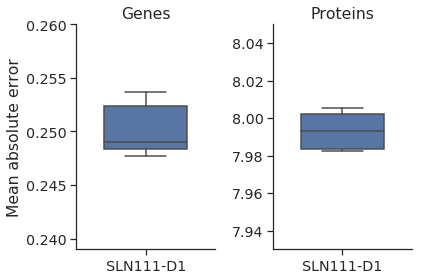

In [49]:
fig, axarr = plt.subplots(1, 2, figsize=(6, 4))
sns.boxplot(
    data=mean_ae_df.transpose().iloc[:, 0], ax = axarr[0], width=0.6
)
axarr[0].set_title("Genes")
axarr[0].set_ylabel("Mean absolute error")

sns.boxplot(
    data=mean_ae_df.transpose().iloc[:, 1], ax=axarr[1], width=0.6
)
axarr[1].set_title("Proteins")
# axarr[1].set_yscale('log')
axarr[0].set_ylim(0.239, 0.26)
axarr[1].set_ylim(7.93, 8.05)
axarr[0].set_xticklabels(["SLN111-D1"])
axarr[1].set_xticklabels(["SLN111-D1"])


sns.despine()
plt.tight_layout()
fig.savefig("figures/ppc_stability_mae.pdf", bbox_inches="tight")

In [14]:
for p in ppc_helds_pbmc:
    p.calibration_error(confidence_intervals=[0.5, 99.5])

          totalVI_0
genes      0.000035
proteins   0.000001
total      0.000032
             totalVI_1
genes     3.547922e-05
proteins  2.415962e-07
total     3.345315e-05
          totalVI_2
genes      0.000038
proteins   0.000003
total      0.000036
          totalVI_3
genes      0.000034
proteins   0.000003
total      0.000032
             totalVI_4
genes     3.607563e-05
proteins  1.871600e-07
total     3.403519e-05


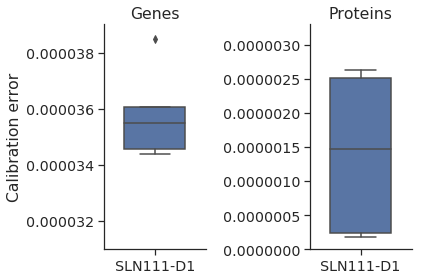

In [48]:
ppc_helds_pbmc[0].metrics["calibration"]

cal_df = pd.DataFrame(index=["genes", "proteins"])
for i, p in enumerate(ppc_helds_pbmc):
    print(p.metrics["calibration"])
    cal_df[p.metrics["calibration"].columns[0]] = p.metrics["calibration"]
    
fig, axarr = plt.subplots(1, 2, figsize=(6, 4))
sns.boxplot(
    data=cal_df.transpose().iloc[:, 0], ax = axarr[0], width=0.6
)
axarr[0].set_title("Genes")
axarr[0].set_ylabel("Calibration error")

sns.boxplot(
    data=cal_df.transpose().iloc[:, 1], ax=axarr[1], width=0.6
)
axarr[1].set_title("Proteins")

axarr[0].set_ylim(0.000031, 0.000039)
axarr[1].set_ylim(0, 0.0000033)
axarr[0].set_xticklabels(["SLN111-D1"])
axarr[1].set_xticklabels(["SLN111-D1"])

sns.despine()
plt.tight_layout()
fig.savefig("figures/ppc_stability_calibration.pdf", bbox_inches="tight")